# Imports

In [49]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import shap

In [2]:
import pycaret
# check version
from pycaret.utils import version
version()

'2.3.6'

In [3]:
#Import everything from PyCaret package for classification
from pycaret.classification import *

In [4]:
plt.rcParams.update({'font.size': 22})

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Modelling

Este bloco de notas assume que foram seguidos os passos do jupyter `Propensity_Data_Prep` ou já existem os dados preparados. A modelagem em `PyCaret` em geral é muito focada em experimentos (como qualquer projeto DS deve ser no início). Portanto, é preciso seguir a estrutura de experimentação que o pacote oferece, felizmente é bastante intuitiva e fácil de usar. O processo de modelagem consistirá nas seguintes etapas:

1. Configure os parâmetros do experimento que incluem
     * Limpeza de dados
     * Transformação de dados
     * Redução de dimensionalidade
     * e muito mais ... (veja a documentação)
2. Compare os modelos disponíveis e escolha os melhores
3. Ajuste os modelos
4. Experimente conjuntos e empilhamento
5. Avalie
6. Salve o modelo
7. Execute outro experimento até estar satisfeito com o desempenho


**Sugestão: Crie 1 notebook por experimento** para não confundir os ambientes de configuração

## Experiment 1: Simple
Neste experimento, é utilizado apenas os dados sobre as transações e sera executar apenas um pré-processamento mínimo. Esta é uma configuração básica para ver qual é o desempenho que se deve esperar.

In [5]:
data = pd.read_csv('./outputs/generated_data.csv')

In [6]:
data.head()

,customer_id,COUNT(transactions),MAX(transactions.coupon_discount),MAX(transactions.other_discount),MAX(transactions.quantity),MAX(transactions.selling_price),MEAN(transactions.coupon_discount),MEAN(transactions.other_discount),MEAN(transactions.quantity),MEAN(transactions.selling_price),MIN(transactions.coupon_discount),MIN(transactions.other_discount),MIN(transactions.quantity),MIN(transactions.selling_price),MODE(transactions.item_id) = 49009.0,MODE(transactions.item_id) = 5798.0,MODE(transactions.item_id) = 9281.0,MODE(transactions.item_id) = 6958.0,MODE(transactions.item_id) = 4649.0,MODE(transactions.item_id) = 4792.0,MODE(transactions.item_id) = 4500.0,MODE(transactions.item_id) = 4409.0,MODE(transactions.item_id) = 5764.0,MODE(transactions.item_id) = 5922.0,MODE(transactions.item_id) is unknown,NUM_UNIQUE(transactions.item_id),SKEW(transactions.coupon_discount),SKEW(transactions.other_discount),SKEW(transactions.quantity),SKEW(transactions.selling_price),STD(transactions.coupon_discount),is_super,COUNT(transactions).1,MAX(transactions.coupon_discount).1,MAX(transactions.other_discount).1,MAX(transactions.quantity).1,MAX(transactions.selling_price).1,MEAN(transactions.coupon_discount).1,MEAN(transactions.other_discount).1,MEAN(transactions.quantity).1,MEAN(transactions.selling_price).1,MIN(transactions.coupon_discount).1,MIN(transactions.other_discount).1,MIN(transactions.quantity).1,MIN(transactions.selling_price).1,MODE(transactions.item_id) = 49009.0.1,MODE(transactions.item_id) = 34047.0,MODE(transactions.item_id) = 9281.0.1,MODE(transactions.item_id) = 5798.0.1,MODE(transactions.item_id) = 6958.0.1,MODE(transactions.item_id) = 4649.0.1,MODE(transactions.item_id) = 4500.0.1,MODE(transactions.item_id) = 45502.0,MODE(transactions.item_id) = 8525.0,MODE(transactions.item_id) = 13174.0,MODE(transactions.item_id) is unknown.1,NUM_UNIQUE(transactions.item_id).1,SKEW(transactions.coupon_discount).1,SKEW(transactions.other_discount).1,SKEW(transactions.quantity).1,SKEW(transactions.selling_price).1,STD(transactions.coupon_discount).1,is_super.1,COUNT(transactions).2,MAX(transactions.coupon_discount).2,MAX(transactions.other_discount).2,MAX(transactions.quantity).2,MAX(transactions.selling_price).2,MEAN(transactions.coupon_discount).2,MEAN(transactions.other_discount).2,MEAN(transactions.quantity).2,MEAN(transactions.selling_price).2,MIN(transactions.coupon_discount).2,MIN(transactions.other_discount).2,MIN(transactions.quantity).2,MIN(transactions.selling_price).2,MODE(transactions.item_id) = 49009.0.2,MODE(transactions.item_id) = 34047.0.1,MODE(transactions.item_id) = 9281.0.2,MODE(transactions.item_id) = 6958.0.2,MODE(transactions.item_id) = 5798.0.2,MODE(transactions.item_id) = 45502.0.1,MODE(transactions.item_id) = 13174.0.1,MODE(transactions.item_id) = 18156.0,MODE(transactions.item_id) = 30851.0,MODE(transactions.item_id) = 30293.0,MODE(transactions.item_id) is unknown.2,NUM_UNIQUE(transactions.item_id).2,SKEW(transactions.coupon_discount).2,SKEW(transactions.other_discount).2,SKEW(transactions.quantity).2,SKEW(transactions.selling_price).2,STD(transactions.coupon_discount).2,is_super.2,COUNT(transactions).3,MAX(transactions.coupon_discount).3,MAX(transactions.other_discount).3,MAX(transactions.quantity).3,MAX(transactions.selling_price).3,MEAN(transactions.coupon_discount).3,MEAN(transactions.other_discount).3,MEAN(transactions.quantity).3,MEAN(transactions.selling_price).3,MIN(transactions.coupon_discount).3,MIN(transactions.other_discount).3,MIN(transactions.quantity).3,MIN(transactions.selling_price).3,MODE(transactions.item_id) = 49009.0.3,MODE(transactions.item_id) = 34047.0.2,MODE(transactions.item_id) = 9281.0.3,MODE(transactions.item_id) = 6958.0.3,MODE(transactions.item_id) = 45502.0.2,MODE(transactions.item_id) = 18156.0.1,MODE(transactions.item_id) = 5798.0.3,MODE(transactions.item_id) = 13174.0.2,MODE(transactions.item_id) = 30851.0.1,MODE(transactions.item_id) = 30293.0.1,MODE(transactions.item_id) is un

In [7]:
data.is_super.value_counts()

0    66741
1    14708
Name: is_super, dtype: int64

### Setup

A configuração do experimento é a seguinte:
1. Prever a coluna is_super
2. Aplique PCA às variáveis de entrada
3. Corrija o desequilíbrio de classe usando SMOTE

In [8]:
list(data.columns)

['customer_id',
 'COUNT(transactions)',
 'MAX(transactions.coupon_discount)',
 'MAX(transactions.other_discount)',
 'MAX(transactions.quantity)',
 'MAX(transactions.selling_price)',
 'MEAN(transactions.coupon_discount)',
 'MEAN(transactions.other_discount)',
 'MEAN(transactions.quantity)',
 'MEAN(transactions.selling_price)',
 'MIN(transactions.coupon_discount)',
 'MIN(transactions.other_discount)',
 'MIN(transactions.quantity)',
 'MIN(transactions.selling_price)',
 'MODE(transactions.item_id) = 49009.0',
 'MODE(transactions.item_id) = 5798.0',
 'MODE(transactions.item_id) = 9281.0',
 'MODE(transactions.item_id) = 6958.0',
 'MODE(transactions.item_id) = 4649.0',
 'MODE(transactions.item_id) = 4792.0',
 'MODE(transactions.item_id) = 4500.0',
 'MODE(transactions.item_id) = 4409.0',
 'MODE(transactions.item_id) = 5764.0',
 'MODE(transactions.item_id) = 5922.0',
 'MODE(transactions.item_id) is unknown',
 'NUM_UNIQUE(transactions.item_id)',
 'SKEW(transactions.coupon_discount)',
 'SKEW(tran

In [9]:
data.filter(regex='is_super.').columns

Index(['is_super.1', 'is_super.2', 'is_super.3', 'is_super.4', 'is_super.5',
       'is_super.6', 'is_super.7'],
      dtype='object')

In [10]:
data = data.drop(['customer_id','is_super.1', 'is_super.2', 'is_super.3', 'is_super.4', 'is_super.5',
       'is_super.6', 'is_super.7'], axis=1)

In [11]:
# Oversampling para balanceamento das classes na porção de treino
# from collections import Counter

# print('Original dataset shape %s' % Counter(traking_sessao_agrupados['target']))

# smote = SMOTE(sampling_strategy='minority', k_neighbors=5, n_jobs=-1, random_state=0)

# X_res, y_res = smote.fit_resample(traking_sessao_agrupados.set_index('user_id').drop(columns=['target']), traking_sessao_agrupados['target'].values)#.drop(columns=['user_id','target','qtd_event'])
# print('Resampled dataset shape %s' % Counter(y_res))


In [12]:
# traking_sessao_agrupados = X_res.rename_axis('user_id').reset_index()
# traking_sessao_agrupados['target'] = y_res
# traking_sessao_agrupados.shape

In [13]:
clf1 = setup(data, target = 'is_super', session_id=123, log_experiment=True, experiment_name='with_pca',
             train_size=0.7,
             pca=True, 
             pca_components=0.95,
             fix_imbalance=True,
             silent=True)

,Description,Value
0,session_id,123
1,Target,is_super
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(81449, 241)"
5,Missing Values,1
6,Numeric Features,143
7,Categorical Features,97
8,Ordinal Features,0
9,High Cardinality Features,0


### Compare the models
Comparar os modelos é um comando de código de uma linha no PyCaret. Especifique a métrica que é mais importante para o problema e o número de modelos principais que deseja manter.

In [14]:
top_models = compare_models(sort='AUC', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7709,0.7162,0.5241,0.3938,0.4496,0.3086,0.3137,2.4700
lightgbm,Light Gradient Boosting Machine,0.7784,0.7134,0.5094,0.4045,0.4508,0.3143,0.3177,0.2120
ada,Ada Boost Classifier,0.7794,0.7093,0.4939,0.4040,0.4443,0.3085,0.3110,0.7540
lr,Logistic Regression,0.8006,0.6758,0.4382,0.4414,0.4398,0.3185,0.3185,1.6640
lda,Linear Discriminant Analysis,0.8047,0.6757,0.4250,0.4504,0.4373,0.3193,0.3195,0.0980
rf,Random Forest Classifier,0.7983,0.6708,0.3970,0.4298,0.4127,0.2911,0.2915,1.9820
et,Extra Trees Classifier,0.8037,0.6626,0.3706,0.4408,0.4026,0.2862,0.2878,1.3360
knn,K Neighbors Classifier,0.7680,0.6622,0.4301,0.3709,0.3982,0.2555,0.2566,4.5380
qda,Quadratic Discriminant Analysis,0.8021,0.6617,0.4064,0.4412,0.4231,0.3039,0.3043,0.0900
nb,Naive Bayes,0.7988,0.6582,0.4044,0.4323,0.4179,0.2964,0.2967,1.0460


### Evaluate 

In [15]:
preds = predict_model(top_models[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7691,0.7182,0.5345,0.4063,0.4616,0.3181,0.3230


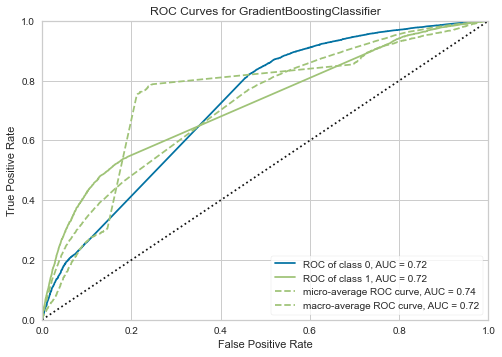

In [16]:
plot_model(top_models[0])

In [17]:
evaluate_model(top_models[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Experiment 2: Advanced

Neste experimento mais avançado, vou trazer os conjuntos de dados dos clientes para aumentar os dados transacionais.

In [18]:
data2 = pd.read_csv('outputs/generated_data.csv')

In [19]:
customers = pd.read_csv('./data/customer_demographics.csv')

In [20]:
data_with_demo = data2.merge(customers, on='customer_id', how='left')
data_with_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81449 entries, 0 to 81448
Columns: 255 entries, customer_id to income_bracket
dtypes: bool(88), float64(154), int64(9), object(4)
memory usage: 111.2+ MB


### Setup

Além do PCA e do SMOTE, nesta configuração também é considerado:
1. Aplicando normalização
2. Transformando os recursos de entrada com Yeo-Johnson
3. Removendo recursos altamente correlacionados
4. Ignorando recursos de baixa variação

In [21]:
clf2 = setup(data_with_demo, target = 'is_super', session_id=123, log_experiment=True, experiment_name='with_demo_pca',
             train_size=0.7, 
             normalize = True, 
             transformation = True, 
             ignore_low_variance = True,
             remove_multicollinearity = True, 
             multicollinearity_threshold = 0.95,
             categorical_features = ['marital_status', 'rented', 'family_size', 'no_of_children', 'age_range', 'income_bracket'], 
             pca=True, pca_components=0.95, 
             fix_imbalance=True,
             silent=True)

,Description,Value
0,session_id,123
1,Target,is_super
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(81449, 255)"
5,Missing Values,1
6,Numeric Features,144
7,Categorical Features,110
8,Ordinal Features,0
9,High Cardinality Features,0


### Compare the models

In [22]:
top_models2 = compare_models(sort='AUC', n_select=5, fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7927,0.8077,0.5924,0.4402,0.5050,0.3775,0.3842,5.5030
rf,Random Forest Classifier,0.7859,0.8073,0.6040,0.4294,0.5019,0.3705,0.3793,8.6260
knn,K Neighbors Classifier,0.7109,0.7655,0.7105,0.3484,0.4675,0.2997,0.3355,3.0110
lightgbm,Light Gradient Boosting Machine,0.7838,0.7583,0.5583,0.4207,0.4798,0.3468,0.3524,1.2800
gbc,Gradient Boosting Classifier,0.7821,0.7374,0.4960,0.4094,0.4483,0.3142,0.3166,14.5970
lr,Logistic Regression,0.7859,0.7152,0.4990,0.4168,0.4541,0.3223,0.3244,1.0620
lda,Linear Discriminant Analysis,0.7891,0.7152,0.4944,0.4226,0.4556,0.3259,0.3275,0.9220
ada,Ada Boost Classifier,0.7738,0.7121,0.4777,0.3911,0.4299,0.2907,0.2930,3.5020
qda,Quadratic Discriminant Analysis,0.7709,0.6954,0.4909,0.3881,0.4334,0.2923,0.2955,0.8570
nb,Naive Bayes,0.6894,0.6639,0.5681,0.3030,0.3951,0.2115,0.2304,0.8390


Já e pode observer que a decisão de incluir mais dados e fazer algum pré-processamento de entrada deu um impulso significativo para a AUC do melhor modelo - **de 0,73 para 0,81**. Vamos ver se podemos obter um pouco mais de desempenho desses modelos fazendo o ajuste de hiperparâmetros.

### Hyperparameter Tuning

HNa tentativa de obter mais desempenho desses modelos é comum realizar uma busca de de hiperparâmetros. Para isso existem diversos métodos, o mais efetivo e ágil segundo a literatura é o que utiliza Otimização Bayesiana, onde um modelo preditivo referido como "substituto" é usado para modelar o espaço de busca e utilizado para chegar a uma boa combinação de valores de parâmetro o mais rápido possível. Parâmetros importantes a considerar:
* **n_iter** - o padrão é 10, mas se tiver tempo, defina-o para 50-100
* **search_library** - pacote que possui o algoritmo que sera utilizado
* **search_algorithm** - o algoritmo que sera utilizado
* **optimize** - métrica a ser otimizada, por padrão, Precisão na classificação. Defina-o como AUC para binário ou F1 para multiclasse
* **choose_better** - substituirá um modelo apenas se for encontrado um modelo melhor. Por padrão, é False, mas defina-o como True.

In [23]:
#Tuning single model
tuned_extra = tune_model(top_models2[0], n_iter=150, optimize = 'AUC', search_library ='scikit-optimize' ,search_algorithm='bayesian', choose_better=True )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7890,0.7434,0.4804,0.4205,0.4484,0.3187,0.3198
1,0.7931,0.7301,0.4705,0.4277,0.4481,0.3211,0.3216
2,0.7952,0.7390,0.4975,0.4359,0.4647,0.3387,0.3399
3,0.8001,0.7458,0.5221,0.4489,0.4828,0.3597,0.3613
4,0.7890,0.7257,0.4705,0.4191,0.4433,0.3137,0.3145
5,0.7897,0.7367,0.4676,0.4201,0.4426,0.3134,0.3141
6,0.7934,0.7248,0.4725,0.4287,0.4495,0.3227,0.3233
7,0.7913,0.7274,0.4735,0.4243,0.4475,0.3193,0.3201
8,0.7937,0.7327,0.4558,0.4273,0.4411,0.3147,0.3150
9,0.8004,0.7592,0.5324,0.4502,0.4878,0.3650,0.3669


In [24]:
#Hold out predictions
holdout_predict = predict_model(tuned_extra)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7713,0.7937,0.6103,0.4194,0.4971,0.3556,0.3661


In [25]:
#Tuneing all 5 best models
tuned_best = [tune_model(m, n_iter=20, optimize = 'AUC', search_library ='scikit-optimize' ,search_algorithm='bayesian', choose_better=True) for m in top_models2]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7894,0.7739,0.5491,0.4297,0.4821,0.3524,0.3565
1,0.7887,0.7604,0.5255,0.4256,0.4703,0.3401,0.3431
2,0.7964,0.7587,0.5584,0.4445,0.4950,0.3695,0.3733
3,0.7908,0.7696,0.5623,0.4341,0.4900,0.3611,0.3659
4,0.7835,0.7577,0.5236,0.4158,0.4635,0.3301,0.3336
5,0.7927,0.7705,0.5619,0.4373,0.4918,0.3641,0.3686
6,0.7883,0.7664,0.5619,0.4291,0.4866,0.3562,0.3614
7,0.7902,0.7582,0.5373,0.4300,0.4777,0.3485,0.3519
8,0.7888,0.7639,0.5393,0.4276,0.4770,0.3469,0.3505
9,0.7935,0.7784,0.5894,0.4415,0.5048,0.3778,0.3841


Os modelos individuais estão ajustados agora, então pode-se experimentá-los no modelo de conjunto

### Ensemble Model

Pode-se fazer a modelagem ensebmle usando o método `blend_models` no PyCaret. Ele simplesmente pega as saídas de todos os modelos de entrada e cria um classificador de votação suave (com probabilidade) ou difícil (0 ou 1). Se a maioria dos modelos votar sim, o exemplo é considerado positivo e vice-versa.

In [26]:
blended = blend_models(estimator_list = tuned_best[:4], method = 'soft') #doesn't take catboost yet

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7613,0.8115,0.6955,0.4025,0.5099,0.3667,0.3906
1,0.7683,0.8138,0.6974,0.4121,0.5181,0.3786,0.4013
2,0.7703,0.8177,0.7134,0.4166,0.5260,0.3879,0.4124
3,0.7659,0.8207,0.7262,0.4120,0.5258,0.3857,0.4130
4,0.7704,0.8105,0.6709,0.4122,0.5107,0.3717,0.3905
5,0.7720,0.8200,0.7063,0.4180,0.5252,0.3879,0.4110
6,0.7660,0.8166,0.6965,0.4089,0.5153,0.3745,0.3976
7,0.7690,0.8182,0.6984,0.4131,0.5192,0.3801,0.4027
8,0.7725,0.8092,0.6876,0.4169,0.5191,0.3816,0.4021
9,0.7706,0.8235,0.7259,0.4180,0.5305,0.3929,0.4191


Como podemos ver, conseguimos um aumento na AUC de 0,8096 para 0,8175 apenas executando 2 linhas de código. Não é um aumento enorme, mas pode ser importante no cenário da vida real. 

### Evaluation

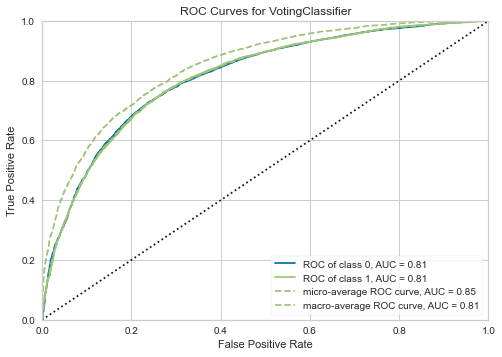

In [27]:
plot_model(blended)

In [28]:
#Hold out predictions
holdout_predict = predict_model(blended, probability_threshold = 0.5) #set new threshold

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7618,0.8131,0.7084,0.4160,0.5242,0.3793,0.4032


O Holdout AUC é de 0,81, portanto, generalizou bem a partir do conjunto de treinamento. A partir do gráfico, podemos escolher o nível aceitável de Verdadeiro Positivo e ver a taxa correspondente de Falsos Positivos. 

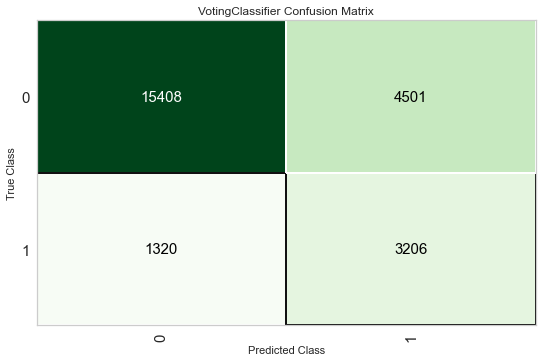

In [29]:
plot_model(blended, plot='confusion_matrix')

Parece que o limite padrão (0,5) é muito alta, pois a maioria dos superclientes é perdida. Vamos ajustá-lo manualmente e ver a nova matriz de confusão.

In [38]:
#Hold out predictions
holdout_predict = predict_model(blended, probability_threshold = 0.45) #set new threshold

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7233,0.8131,0.7751,0.3792,0.5092,0.3467,0.3897


In [39]:
print(holdout_predict.shape)
holdout_predict.head()

(24435, 43)


,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_34,Component_35,Component_36,Component_37,Component_38,Component_39,Component_40,is_super,Label,Score
0,3.1983,-2.0042,2.2523,1.7008,1.7324,-3.8863,-0.1754,0.6651,1.2250,3.8616,...,-0.1198,-0.6836,1.4593,-1.0427,0.9686,-0.0073,-0.8578,0,0,0.5622
1,7.0631,-2.7926,-8.5681,-5.2613,4.4781,1.4696,1.2402,-4.1118,-0.9424,-1.6650,...,0.0749,-0.1684,0.6433,0.0819,0.2667,0.5260,0.0496,0,0,0.6833
2,6.2821,4.7644,2.7261,-5.5904,-3.2012,4.5063,-0.4434,-3.1265,1.9259,1.5363,...,0.5447,-0.4485,0.6788,-0.1050,-0.0451,0.0293,-0.2625,0,0,0.8063
3,-2.8281,1.3816,-0.4477,-0.5832,-0.1044,-0.4653,-0.2281,0.1586,0.0379,-0.1815,...,0.0019,-0.0045,-0.0008,-0.0041,0.0064,-0.0114,0.0227,0,0,0.8375
4,4.9554,-0.2709,-1.2785,-2.7770,0.9644,-6.0131,2.3647,-1.2617,3.0510,0.8803,...,-0.4794,-0.7094,-0.3486,-0.2371,1.0739,-0.0718,-0.3640,0,0,0.6915


In [40]:
holdout_predict[['is_super','Label']].info()
holdout_predict['is_super'] = holdout_predict['is_super'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_super  24435 non-null  int64
 1   Label     24435 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 286.5 KB


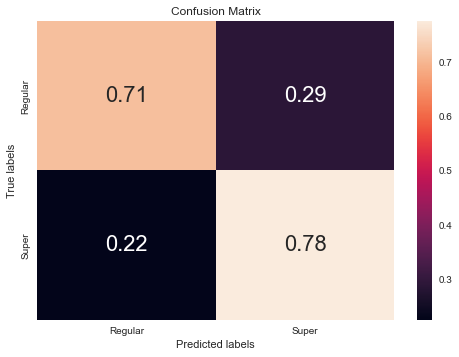

In [44]:
labels = [0,1]
cm = confusion_matrix(holdout_predict['is_super'], holdout_predict['Label'], labels, normalize='true')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Regular', 'Super']); ax.yaxis.set_ticklabels(['Regular', 'Super']);

## Interpret Model

In [50]:
f = lambda x: blended.predict_proba(x)[:,1]
med = get_config('X_train').median().values.reshape((1,get_config('X_train').shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(get_config('X_test').iloc[0:1000,:])

Permutation explainer: 1001it [14:38,  1.13it/s]                          


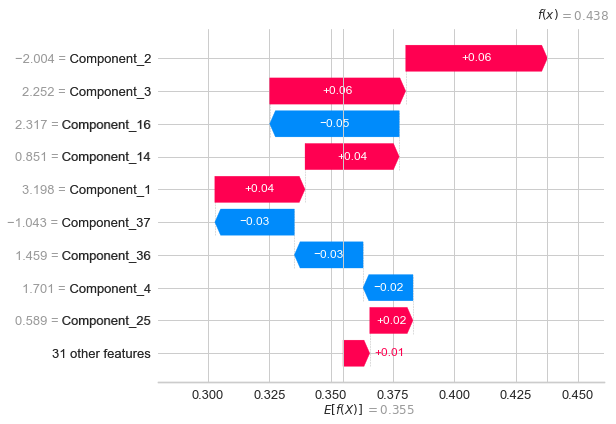

In [51]:
shap.plots.waterfall(shap_values[0])

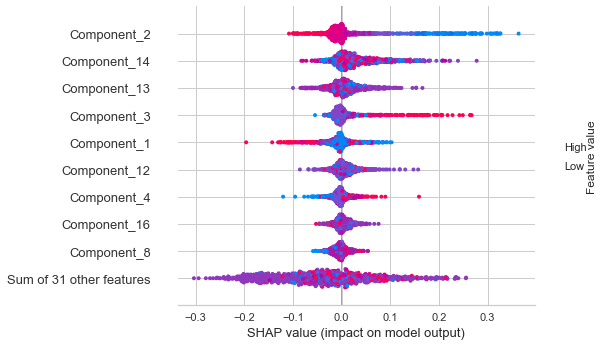

In [52]:
shap.plots.beeswarm(shap_values)

## Deployment

Esta etapa não é a implantação propriamente dita, mas estamos salvando o modelo para uso posterior. Observe que não é apenas o modelo que é salvo, mas também todo o pipeline de pré-processamento. Isso permite que seus resultados sejam replicáveis.

In [45]:
#retrains on the entire data
final_model = finalize_model(blended)

In [46]:
#saving
save_model(final_model,'model/Final Blend Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['marital_status',
                                                             'rented',
                                                             'family_size',
                                                             'no_of_children',
                                                             'age_range',
                                                             'income_bracket'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='is_super',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_stra...
                                                               max